# Stellar Classification  

The objective of this notebook is to classify objects into different classes based on their attributes. The dataset used in this notebook is taken from the Kaggle dataset [Star Type Classification](https://www.kaggle.com/deepu1109/star-dataset). The dataset contains the following columns:

| Column Name | Description |
|-------------|-------------|
| `obj_ID` | Object Identifier, the unique value that identifies the object in the image catalog used by the CAS |
| `alpha` | Right Ascension angle (at J2000 epoch) |
| `delta` | Declination angle (at J2000 epoch) |
| `u` | Ultraviolet filter in the photometric system |
| `g` | Green filter in the photometric system |
| `r` | Red filter in the photometric system |
| `i` | Near Infrared filter in the photometric system |
| `z` | Infrared filter in the photometric system |
| `run_ID` | Run Number used to identify the specific scan |
| `rerun_ID` | Rerun Number to specify how the image was processed |
| `cam_col` | Camera column to identify the scanline within the run |
| `field_ID` | Field number to identify each field |
| `spec_obj_ID` | Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class) |
| `class` | Object class (galaxy, star, or quasar object) |
| `redshift` | Redshift value based on the increase in wavelength |
| `plate` | Plate ID, identifies each plate in SDSS |
| `MJD` | Modified Julian Date, used to indicate when a given piece of SDSS data was taken |
| `fiber_ID` | Fiber ID that identifies the fiber that pointed the light at the focal plane in each observation |


We will test different classification algorithms to classify the objects into different classes based on their attributes. The following classification algorithms will be tested:

- Random Forest
- Support Vector Machine

We will also try Deep Learning models. 


In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm

import tensorflow as tf
from tensorflow.keras import layers, models

### Load and exploration of the dataset

In [10]:
filename = 'star_classification.csv'
data = pd.read_csv(filename)
data.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [11]:
rows,columns = data.shape
print(f"Number of rows/examples: {rows}")
print(f"Number of columns/features: {columns}")

Number of rows/examples: 100000
Number of columns/features: 18


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
obj_ID,100000.0,1.237665e+18,8.438560e+12,1.237646e+18,1.237659e+18,1.237663e+18,1.237668e+18,1.237681e+18
alpha,100000.0,1.776291e+02,9.650224e+01,5.527828e-03,1.275182e+02,1.809007e+02,2.338950e+02,3.599998e+02
delta,100000.0,2.413530e+01,1.964467e+01,-1.878533e+01,5.146771e+00,2.364592e+01,3.990155e+01,8.300052e+01
u,100000.0,2.198047e+01,3.176929e+01,-9.999000e+03,2.035235e+01,2.217914e+01,2.368744e+01,3.278139e+01
g,100000.0,2.053139e+01,3.175029e+01,-9.999000e+03,1.896523e+01,2.109983e+01,2.212377e+01,3.160224e+01
r,100000.0,1.964576e+01,1.854760e+00,9.822070e+00,1.813583e+01,2.012529e+01,2.104478e+01,2.957186e+01
i,100000.0,1.908485e+01,1.757895e+00,9.469903e+00,1.773228e+01,1.940514e+01,2.039650e+01,3.214147e+01
z,100000.0,1.866881e+01,3.172815e+01,-9.999000e+03,1.746068e+01,1.900460e+01,1.992112e+01,2.938374e+01
run_ID,100000.0,4.481366e+03,1.964765e+03,1.090000e+02,3.187000e+03,4.188000e+03,5.326000e+03,8.162000e+03
rerun_ID,100000.0,3.010000e+02,0.000000e+00,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02


In [14]:
#we check for missing values
missing_values = data.isnull().sum()
print(missing_values)


obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64


In [15]:
data["class"].value_counts() # class = object class (galaxy, star or quasar object)

GALAXY    59445
STAR      21594
QSO       18961
Name: class, dtype: int64

Data Visualization and Exploration

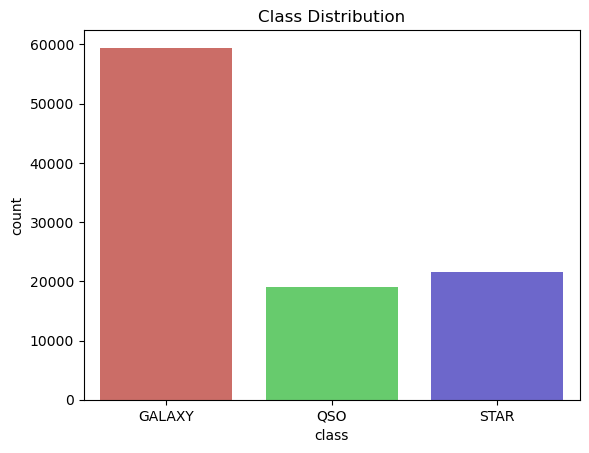

In [16]:
sns.countplot(x="class", data=data, palette="hls")
plt.title("Class Distribution")
plt.show()


We will encode the values of the target variable `class` to integers because they are not presented numerically.

In [17]:
LE = LabelEncoder()
data["class"] = LE.fit_transform(data["class"])
print("New class values: 0 for GALAXY, 1 for STAR, 2 for QUASAR")
print(data["class"].value_counts())


New class values: 0 for GALAXY, 1 for STAR, 2 for QUASAR
0    59445
2    21594
1    18961
Name: class, dtype: int64


We will check for the values that have the least correlation with the target variable and remove them from the dataset.

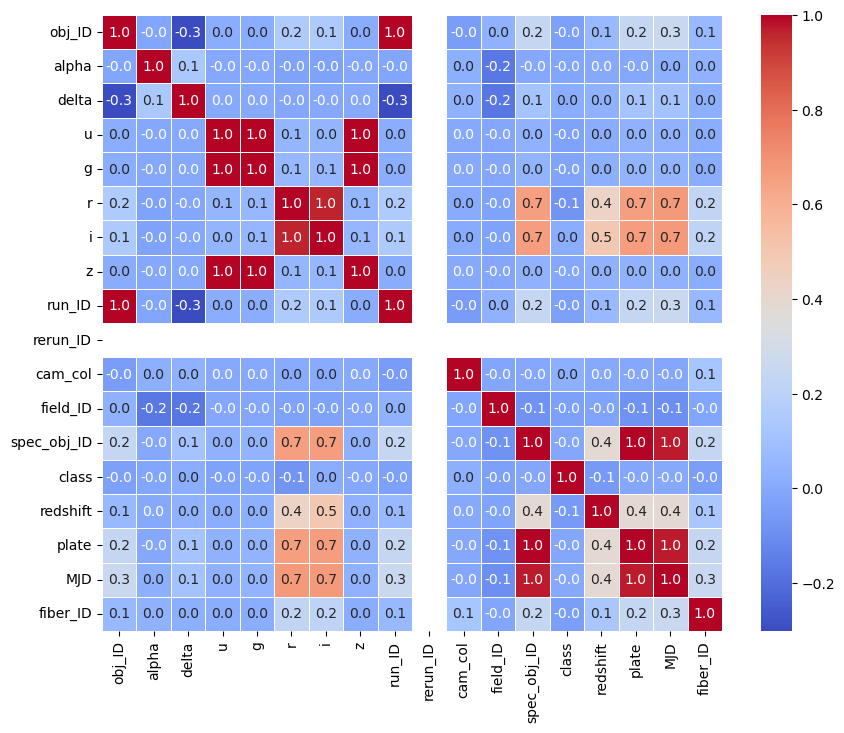

In [18]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

From the correlation matrix we can deduce that the columns `obj_ID`, `alpha`, `delta`, `run_ID`, `rerun_ID`, `cam_col`, `field_ID`, `spec_obj_ID`, `plate`, `MJD`, and `fiber_ID` have the least correlation with the target variable. We will remove these columns from the dataset.

In [19]:
data= data.drop(['obj_ID','alpha','delta','run_ID','rerun_ID','cam_col','field_ID','fiber_ID'], axis = 1)

We split the dataset into X and Y, and then into training and testing sets.

In [20]:
X = data.drop("class", axis=1)
Y = data["class"]
X

,u,g,r,i,z,spec_obj_ID,redshift,plate,MJD
0,23.87882,22.27530,20.39501,19.16573,18.79371,6.543777e+18,0.634794,5812,56354
1,24.77759,22.83188,22.58444,21.16812,21.61427,1.176014e+19,0.779136,10445,58158
2,25.26307,22.66389,20.60976,19.34857,18.94827,5.152200e+18,0.644195,4576,55592
3,22.13682,23.77656,21.61162,20.50454,19.25010,1.030107e+19,0.932346,9149,58039
4,19.43718,17.58028,16.49747,15.97711,15.54461,6.891865e+18,0.116123,6121,56187
...,...,...,...,...,...,...,...,...,...
99995,22.16759,22.97586,21.90404,21.30548,20.73569,1.055431e+19,0.000000,9374,57749
99996,22.69118,22.38628,20.45003,19.75759,19.41526,8.586351e+18,0.404895,7626,56934
99997,21.16916,19.26997,18.20428,17.69034,17.35221,3.112008e+18,0.143366,2764,54535
99998,25.35039,21.63757,19.91386,19.07254,18.62482,7.601080e+18,0.455040,6751,56368


We will perform data standardization to balance the scale of the features to facilitate the training of the model.

In [21]:
standard = StandardScaler()
X = standard.fit_transform(X)

We split into training and test sets: 80% of the data will be used for training and 20% for testing.

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [23]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")


X_train shape: (80000, 9)
X_test shape: (20000, 9)
Y_train shape: (80000,)
Y_test shape: (20000,)


### Classification models 

##### Random Forest Classifier

In [66]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
print(f"Accuracy: {random_forest.score(X_test, Y_test)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred)}")

Accuracy: 0.98
Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11860
           1       0.97      0.93      0.95      3797
           2       1.00      1.00      1.00      4343

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.98     20000
weighted avg       0.98      0.98      0.98     20000



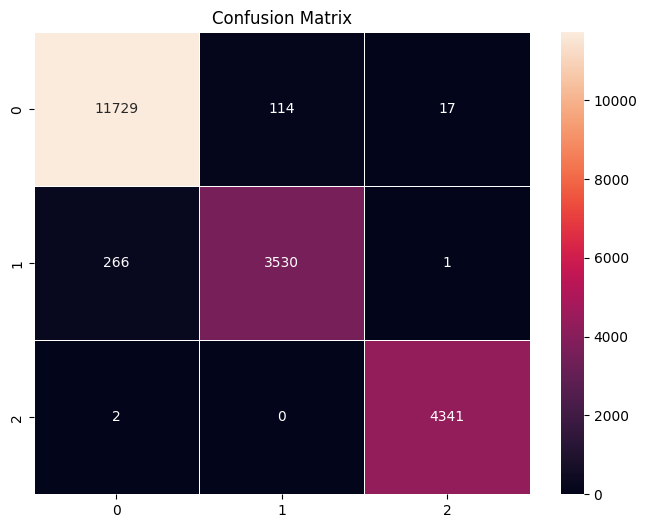

In [67]:
#confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix")
plt.show()


Remarks: According to the previous confusion matrix:

- We see a high accuracy for class 0 and class 2, with most of their instances being correctly identified.
- Class 1 shows more misclassification both in terms of false negatives and false positives, though the number is relatively small compared to correct predictions.


##### Decision Tree Classifier

In [68]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
print(f"Accuracy: {decision_tree.score(X_test, Y_test)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred)}")

Accuracy: 0.9669
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     11860
           1       0.92      0.92      0.92      3797
           2       1.00      0.99      1.00      4343

    accuracy                           0.97     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.97      0.97      0.97     20000



##### Gradient Boosting Classifier

In [69]:
gradient_boosting = GradientBoostingClassifier()
gradient_boosting.fit(X_train, Y_train)
Y_pred = gradient_boosting.predict(X_test)
print(f"Accuracy: {gradient_boosting.score(X_test, Y_test)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred)}")

Accuracy: 0.9765
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11860
           1       0.97      0.91      0.94      3797
           2       1.00      1.00      1.00      4343

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



##### Support Vector Machine

In [70]:
svm_model = svm.SVC()
svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)
print(f"Accuracy: {svm_model.score(X_test, Y_test)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred)}")


Accuracy: 0.9614
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     11860
           1       0.97      0.90      0.93      3797
           2       0.94      1.00      0.97      4343

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000



##### We test our models

In [71]:
test_data = pd.DataFrame({
    "model": ["Random Forest", "Decision Tree", "Gradient Boosting", "SVM"],
    "accuracy": [random_forest.score(X_test, Y_test), decision_tree.score(X_test, Y_test), gradient_boosting.score(X_test, Y_test), svm_model.score(X_test, Y_test)]
})
test_data


,model,accuracy
0,Random Forest,0.9800
1,Decision Tree,0.9669
2,Gradient Boosting,0.9765
3,SVM,0.9614


We will now make predictions on a random instance from the test set

In [72]:
np.random.seed(43) 
random_index = np.random.randint(0, len(X_test))
test_instance = X_test[random_index].reshape(1, -1)
expected_class = Y_test.iloc[random_index] 

In [73]:
rf_prediction = random_forest.predict(test_instance)
dt_prediction = decision_tree.predict(test_instance)
gb_prediction = gradient_boosting.predict(test_instance)
svm_prediction = svm_model.predict(test_instance)

In [74]:
print("Predictions:")
print(f"Random Forest: {rf_prediction[0]}, Expected: {expected_class}")
print(f"Decision Tree: {dt_prediction[0]}, Expected: {expected_class}")
print(f"Gradient Boosting: {gb_prediction[0]}, Expected: {expected_class}")
print(f"SVM: {svm_prediction[0]}, Expected: {expected_class}")

Predictions:
Random Forest: 2, Expected: 2
Decision Tree: 2, Expected: 2
Gradient Boosting: 2, Expected: 2
SVM: 2, Expected: 2


We predicted a Quasar correctly for all the models.

### Deep Learning models 

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(32)


In [46]:
class Stellar_Classifier(tf.keras.Model):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes, dropout):
        super(Stellar_Classifier, self).__init__()
        self.dropout = layers.Dropout(dropout)
        self.layer1 = layers.Dense(hidden_size1, activation=None)
        self.act1 = layers.ReLU()
        self.norm1 = layers.BatchNormalization()
        
        self.layer2 = layers.Dense(hidden_size2, activation=None)
        self.act2 = layers.ReLU()
        self.norm2 = layers.BatchNormalization()

        self.layer3 = layers.Dense(hidden_size3, activation=None)
        self.act3 = layers.ReLU()
        self.norm3 = layers.BatchNormalization()

        self.output_layer = layers.Dense(num_classes, activation=None)
        
    def call(self, inputs):
        x = self.layer1(inputs)
        x = self.act1(x)
        x = self.norm1(x)
        x = self.dropout(x)
        
        x = self.layer2(x)
        x = self.act2(x)
        x = self.norm2(x)
        x = self.dropout(x)

        x = self.layer3(x)
        x = self.act3(x)
        x = self.norm3(x)
        x = self.dropout(x)

        return self.output_layer(x)


model = Stellar_Classifier(input_size=9, hidden_size1=64, hidden_size2=128, hidden_size3=256, num_classes=5, dropout=0.5)


Epoch 1/100
2500/2500 - 8s - loss: 0.3788 - accuracy: 0.8753 - val_loss: 0.1440 - val_accuracy: 0.9537 - 8s/epoch - 3ms/step
Epoch 2/100
2500/2500 - 5s - loss: 0.2010 - accuracy: 0.9355 - val_loss: 0.1278 - val_accuracy: 0.9617 - 5s/epoch - 2ms/step
Epoch 3/100
2500/2500 - 5s - loss: 0.1798 - accuracy: 0.9444 - val_loss: 0.1228 - val_accuracy: 0.9658 - 5s/epoch - 2ms/step
Epoch 4/100
2500/2500 - 5s - loss: 0.1674 - accuracy: 0.9484 - val_loss: 0.1244 - val_accuracy: 0.9624 - 5s/epoch - 2ms/step
Epoch 5/100
2500/2500 - 7s - loss: 0.1602 - accuracy: 0.9520 - val_loss: 0.1174 - val_accuracy: 0.9654 - 7s/epoch - 3ms/step
Epoch 6/100
2500/2500 - 7s - loss: 0.1553 - accuracy: 0.9542 - val_loss: 0.1137 - val_accuracy: 0.9671 - 7s/epoch - 3ms/step
Epoch 7/100
2500/2500 - 7s - loss: 0.1512 - accuracy: 0.9548 - val_loss: 0.1153 - val_accuracy: 0.9665 - 7s/epoch - 3ms/step
Epoch 8/100
2500/2500 - 7s - loss: 0.1469 - accuracy: 0.9567 - val_loss: 0.1104 - val_accuracy: 0.9669 - 7s/epoch - 3ms/step


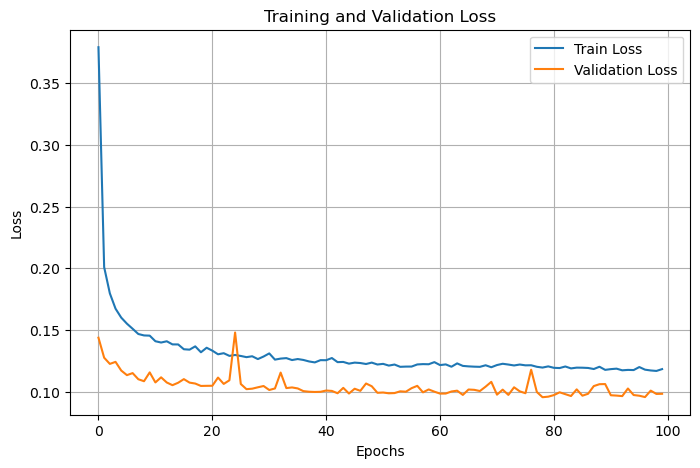

In [29]:
def train_model(model, train_data, epochs, learning_rate, val_data=None):
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
  
    history = model.fit(train_data, epochs=epochs, validation_data=val_data, verbose=2)
    
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    if val_data is not None:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return history


history = train_model(model, train_data=train_dataset, epochs=100, learning_rate=0.001, val_data=val_dataset)


In [31]:
def test_model(model, test_data):
    test_loss, test_accuracy = model.evaluate(test_data)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    return test_loss, test_accuracy


In [32]:
test_loss, test_accuracy = test_model(model, val_dataset)

 58/625 [=>............................] - ETA: 0s - loss: 0.1141 - accuracy: 0.9677 

625/625 [==============================] - 0s 670us/step - loss: 0.0986 - accuracy: 0.9706
Test Loss: 0.09860867261886597, Test Accuracy: 0.9706000089645386


In [42]:
for x_test, y_test in val_dataset:
    predictions = model.predict(x_test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = y_test.numpy()
    break

print("Predictions:", predicted_classes)
print("True labels:", true_classes)


1/1 [==============================] - 0s 19ms/step
Predictions: [0 2 2 2 2 0 0 1 0 0 0 0 0 2 0 0 2 0 0 0 0 0 2 0 1 0 0 0 0 1 2 0]
True labels: [0 2 2 2 2 1 0 1 0 0 0 0 0 2 0 1 2 0 0 0 0 0 2 0 1 0 0 0 0 1 2 0]


In [44]:
all_predicted_classes = []
all_true_classes = []

for x_test, y_test in val_dataset:
    predictions = model.predict(x_test)
    predicted_classes = np.argmax(predictions, axis=1)
    all_predicted_classes.extend(predicted_classes)
    all_true_classes.extend(y_test.numpy())

all_predicted_classes = np.array(all_predicted_classes)
all_true_classes = np.array(all_true_classes)



1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step


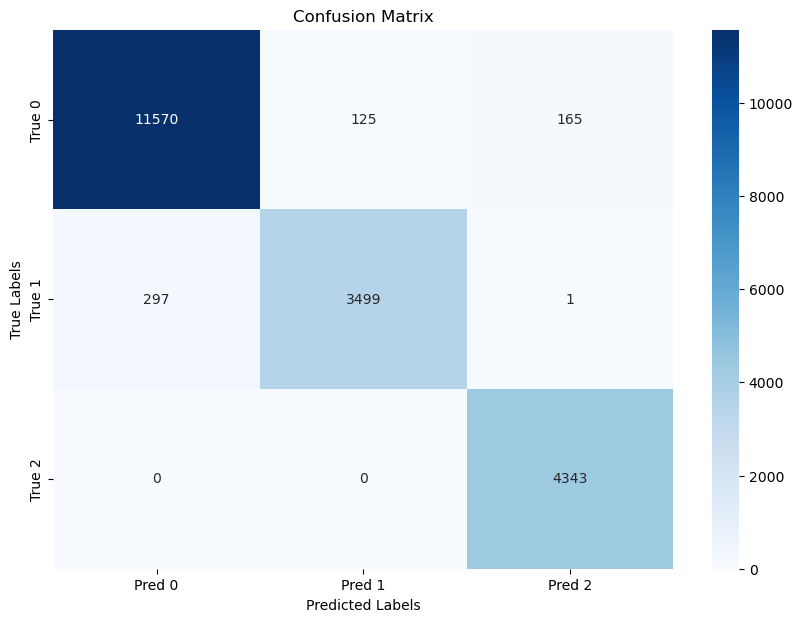

In [45]:
cm = confusion_matrix(all_true_classes, all_predicted_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=[f"Pred {i}" for i in range(cm.shape[1])], yticklabels=[f"True {i}" for i in range(cm.shape[0])])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
